## Hypothesis I - Baseline Model

##### Input: Vegetation Indices + Texture Properties + Thermal Features

##### Downstream Model: LASSO Model

##### Validation: 5-fold CV


In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import shap

import joblib

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Preprocessing


In [4]:
LATE_BOOT_DATES = ["2021-06-14", "2021-06-23", "2021-06-30", "2021-07-28"]

# load 2021 data
df_2021 = pd.read_csv("../../../Datasets/2021/Dataset_2021.csv")
df_2021 = df_2021.sort_values(by=["Date", "Plot_Number"])

# remove missing yield
df_2021 = df_2021[df_2021["Yield"].notna()]

# Only keep dates that occur on/before late booting stage
df_2021["Date"] = pd.to_datetime(df_2021["Date"]).dt.strftime("%Y-%m-%d")
df_2021 = df_2021[df_2021["Date"].isin(LATE_BOOT_DATES)]

# remove vegetation fraction
df_2021.drop("Vegetation_Fraction", axis=1, inplace=True)

**Split Plots into Train/Test** <br>
The split is done in a leave-one-replicate-out fashion. For each group of plots, one replicate is left out for validaiton while the rest is trained on.


In [5]:
seedCounter = 100
trainPlots = []
testPlots = []
tmp = df_2021[df_2021["Date"] == df_2021["Date"].unique()[0]]

for e in tmp["Experiment_Name"].unique():
    for c in tmp[tmp["Experiment_Name"] == e]["Rice_Cultivar"].unique():
        for n in tmp[(tmp["Experiment_Name"] == e) & (tmp["Rice_Cultivar"] == c)][
            "Nitrogen_Rate"
        ].unique():
            replicates = tmp[
                (tmp["Experiment_Name"] == e)
                & (tmp["Rice_Cultivar"] == c)
                & (tmp["Nitrogen_Rate"] == n)
            ]["Replicate"].unique()

            # set seed for each random pick for reproducibility
            np.random.seed(seedCounter)
            picked = np.random.choice(replicates)
            seedCounter += 1

            train = tmp[
                (tmp["Experiment_Name"] == e)
                & (tmp["Rice_Cultivar"] == c)
                & (tmp["Nitrogen_Rate"] == n)
                & (tmp["Replicate"] != picked)
            ]["Plot_Number"].values

            test = tmp[
                (tmp["Experiment_Name"] == e)
                & (tmp["Rice_Cultivar"] == c)
                & (tmp["Nitrogen_Rate"] == n)
                & (tmp["Replicate"] == picked)
            ]["Plot_Number"].values

            print(
                f"Experiment: {e}, Cultivar: {c}, Nitrogen: {n} \n"
                f"Train plots: {train}\n"
                f"Test plots: {test}\n"
                f"---------------------------------------------------------------"
            )

            trainPlots.extend(train)
            testPlots.extend(test)

del e, c, n, replicates, seedCounter

Experiment: Tiara, Cultivar: IAC600, Nitrogen: 75 
Train plots: [33769 33771 33779 33783]
Test plots: [33761 33766]
---------------------------------------------------------------
Experiment: Tiara, Cultivar: IAC600, Nitrogen: 150 
Train plots: [33786 33788 33801 33807]
Test plots: [33795 33798]
---------------------------------------------------------------
Experiment: Tiara, Cultivar: IAC600, Nitrogen: 200 
Train plots: [33821 33822 33826 33832]
Test plots: [33810 33816]
---------------------------------------------------------------
Experiment: Tiara, Cultivar: Tiara, Nitrogen: 75 
Train plots: [33762 33765 33777 33781]
Test plots: [33773 33775]
---------------------------------------------------------------
Experiment: Tiara, Cultivar: Tiara, Nitrogen: 150 
Train plots: [33785 33792 33803 33804]
Test plots: [33794 33799]
---------------------------------------------------------------
Experiment: Tiara, Cultivar: Tiara, Nitrogen: 200 
Train plots: [33820 33824 33830 33831]
Test plot

In [6]:
dfTrain = df_2021[df_2021["Plot_Number"].isin(trainPlots)]

# scale features (using late Boot dates)
scaler = StandardScaler()
dfTrain.iloc[:, 17:] = scaler.fit_transform(dfTrain.iloc[:, 17:])

# widen dataset
dfLongTrain = pd.melt(
    dfTrain.iloc[:, np.r_[0:8, 17 : len(dfTrain.columns)]],
    id_vars=dfTrain.iloc[:, 0:8],
    value_vars=dfTrain.iloc[:, 17:],
)

dfWideTrain = pd.pivot(
    dfLongTrain,
    columns=["Date", "variable"],
    values="value",
    index=[
        "Plot_Number",
        "Rice_Cultivar",
        "Experiment_Name",
        "Bay_Length",
        "Nitrogen_Rate",
        "Replicate",
        "Yield",
    ],
).reset_index()

dfWideTrain.columns = [
    str(s1) + "_" + str(s2) if str(s2) != "" else str(s1)
    for (s1, s2) in dfWideTrain.columns.tolist()
]

### Training


In [7]:
def lassoCV_custom(xTrain, yTrain, nfolds, alpha=1):
    kfold = KFold(n_splits=nfolds, shuffle=True, random_state=100)

    cvResults = []
    for trainIndices, valIndices in kfold.split(xTrain):
        xTrainCV, xValCV = xTrain[trainIndices], xTrain[valIndices]
        yTrainCV, yValCV = yTrain[trainIndices], yTrain[valIndices]

        # fit model
        lassoModel = Lasso(max_iter=10000, alpha=alpha)
        lassoModel.fit(xTrainCV, yTrainCV)
        preds = lassoModel.predict(xValCV)
        cvResults.append(mean_squared_error(yValCV, preds, squared=False))

    return cvResults

In [8]:
xTrain = dfWideTrain.iloc[:, 7:].values
yTrain = dfWideTrain["Yield"]
N_FOLDS = 5

defaultModel = Lasso(max_iter=10000).fit(xTrain, yTrain)

print(f"RMSE 5-fold CV: {np.mean(lassoCV_custom(xTrain, yTrain, N_FOLDS))}")
print(
    f"Training RMSE: {mean_squared_error(yTrain, defaultModel.predict(xTrain), squared=False)}"
)

RMSE 5-fold CV: 2.616123158132356
Training RMSE: 2.5868434464261605


### Tuning Lambda


In [9]:
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=100)
tunedModel = LassoCV(max_iter=10000, cv=cv, n_jobs=-1).fit(xTrain, yTrain)

### Visualize CV


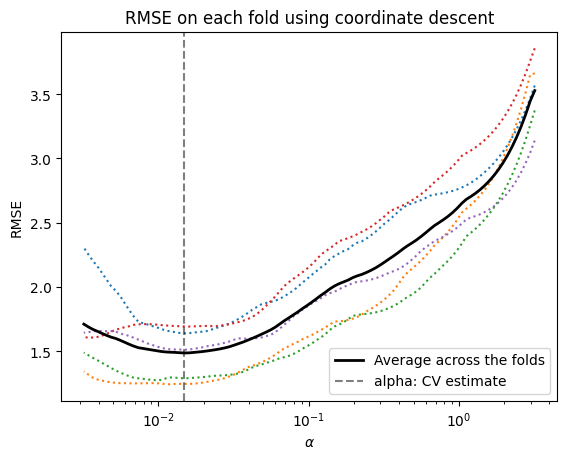

In [10]:
plt.semilogx(tunedModel.alphas_, tunedModel.mse_path_**0.5, linestyle=":")
plt.plot(
    tunedModel.alphas_,
    tunedModel.mse_path_.mean(axis=-1) ** 0.5,
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    tunedModel.alpha_,
    linestyle="--",
    color="black",
    label="alpha: CV estimate",
    alpha=0.5,
)

plt.xlabel(r"$\alpha$")
plt.ylabel("RMSE")
plt.legend()
_ = plt.title(f"RMSE on each fold using coordinate descent")

In [11]:
print(
    f"RMSE 5-fold CV: {np.mean(lassoCV_custom(xTrain, yTrain, N_FOLDS, tunedModel.alpha_))}"
)
print(
    f"Training RMSE: {mean_squared_error(yTrain, tunedModel.predict(xTrain), squared=False)}"
)

RMSE 5-fold CV: 1.4763598076723687
Training RMSE: 1.0613274584478485


### Interpret Model


In [10]:
explainer = shap.Explainer(lambda x: tunedModel.predict(x), xTrain)
shapValues = explainer(xTrain)

Permutation explainer: 152it [00:16,  4.44it/s]                         


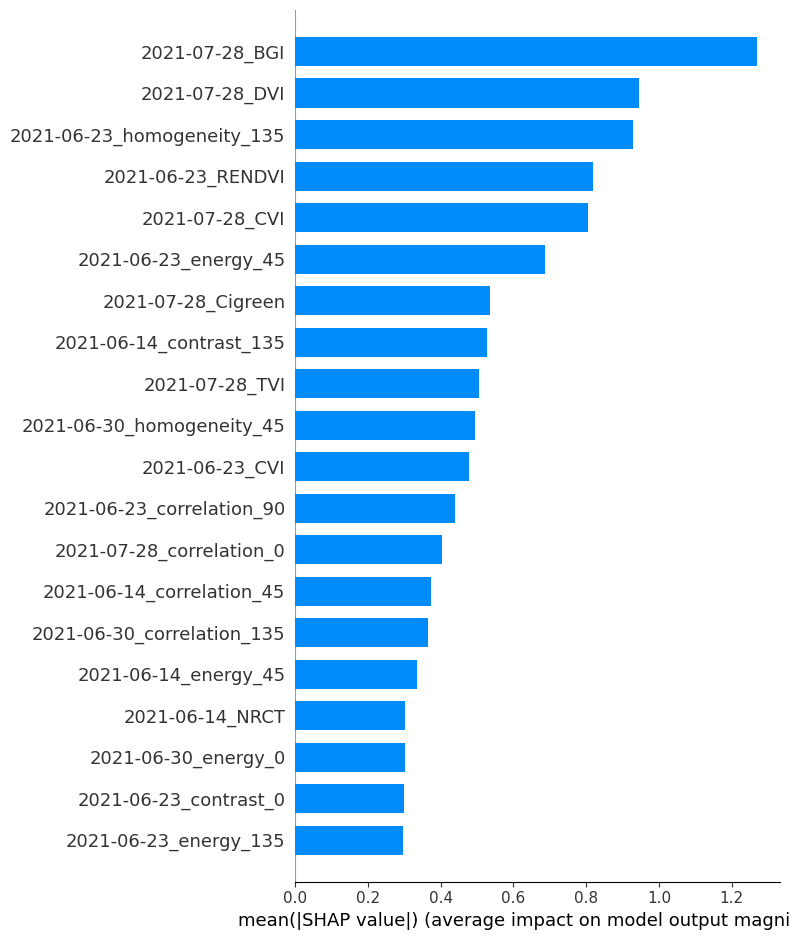

In [11]:
shap.summary_plot(shapValues, plot_type="bar", feature_names=dfWideTrain.columns[7:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


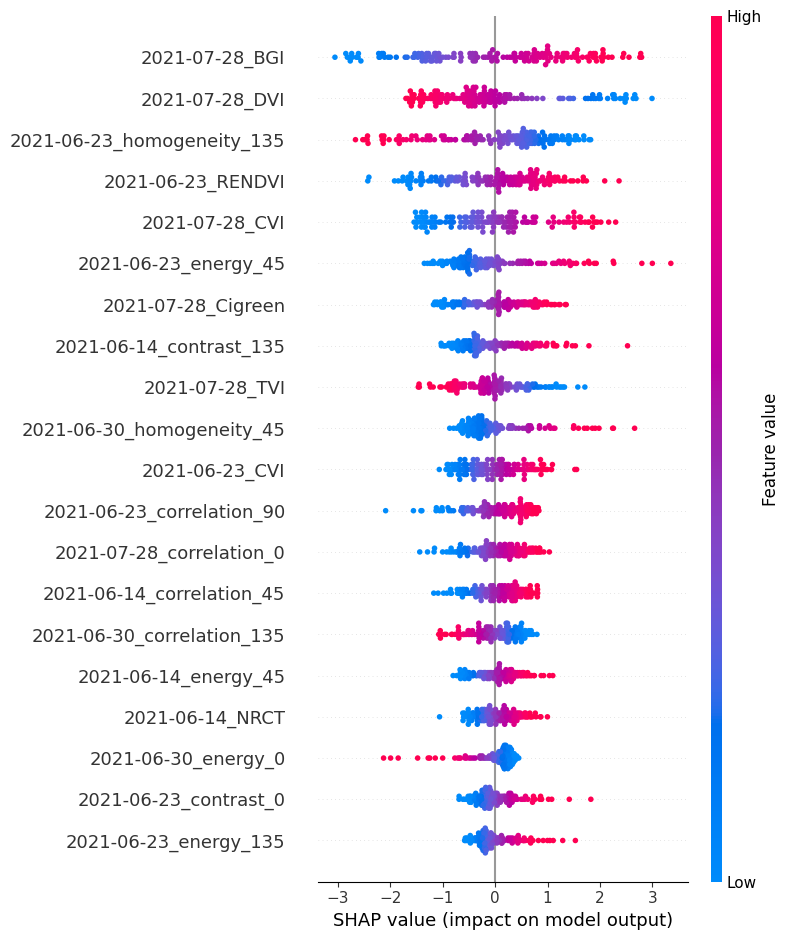

In [12]:
shap.summary_plot(shapValues, plot_type="dot", feature_names=dfWideTrain.columns[7:])

### Export Model


In [ ]:
# save tuned model
joblib.dump(tunedModel, "./Saved_Models/Baseline_LASSO")